# Add em up model

## Overview

Given the bikes that have departed so far today, how many bikes will be available at all stations in the next 30 minutes? 

Calculate the historical destination probabilities for all stations in 5 minute increments by month and day type.

When a bike leaves a given station, add the conditional probabilities of arriving at all stations to the bins of each destination station (at the average time of bikes traveling between the start and end station). 

For each station, when the bins have over a certain threshold (0.50?), shave off the extra and have that extra be the new probabilitiy binned, and +1 to the incoming bike counter. Departures will be based on historical averages for that station during that interval. 


## Load May data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pprint
%load_ext autoreload
from pylab import rcParams
from pymc3 import  *

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [103]:
may_2015 = pd.read_csv('~/Code/bikesupply/data/test_data/trips_may2015.csv', parse_dates = ['start_date'])
may_2016 = pd.read_csv('~/Code/bikesupply/data/test_data/trips_may2016.csv', parse_dates = ['start_date'])

In [104]:
def extract_times_from_timestamp(data):
    data['start_date'] = pd.to_datetime(data['start_date'])
    data = data.set_index('start_date')
    data['weekday'] = [ts.weekday() for ts in data.index]
    data['start_hour'] = [ts.hour for ts in data.index]
    data['start_minutes'] = [ts.minute for ts in data.index]
    data['start_time_in_mins'] = (data['start_day'] * 1440) + (data['start_hour'] * 60) + data['start_minutes']
    data = data.reset_index()
    data['end_date'] = pd.to_datetime(data['end_date'])
    data = data.set_index('end_date')
    data['end_hour'] = [ts.hour for ts in data.index]
    data['end_minutes'] = [ts.minute for ts in data.index]
    data['end_time_in_mins'] = (data['end_day'] * 1440) + (data['end_hour'] * 60) + data['end_minutes']
    data = data.reset_index()  
    
    return data

In [105]:
may_2015 = extract_times_from_timestamp(may_2015)

In [107]:
may_2016 = extract_times_from_timestamp(may_2016)

## Weekday probability distribution

Very small training sample when we restrict by day type. What if we grouped all weekdays for that same time block?

In [226]:
may_2015_weekdays = may_2015.query("weekday >= 0 and weekday <= 4")

In [227]:
len(may_2015_weekdays)

26055

In [228]:
station_50 = may_2015_weekdays.query("start_station_id == 50")
station_ids = station_50.groupby(['end_station_id'])['trip_id'].count() / len(station_50)

In [222]:
may_2_2016 = may_2016.query('start_day == 2 and start_station_id == 50')
len(may_2_2016)

60

In [223]:
may_2_stations = may_2_2016.groupby(['end_station_id'])['trip_id'].count() 

In [264]:
binned_data = station_ids * 60

In [260]:
binned_data = binned_data[binned_data >= .5]

In [265]:
binned_data

end_station_id
39     1.086420
41     0.444444
42     0.345679
45     0.592593
46     0.098765
47     1.283951
48     1.086420
49     0.395062
50     1.679012
51     0.049383
54     1.679012
55     0.888889
56     0.098765
57     1.925926
58     0.197531
59     0.246914
60    11.950617
61     9.481481
62     2.271605
63     1.382716
64     2.518519
65     2.172840
66     0.345679
67     0.790123
68     2.469136
69     1.679012
70     7.506173
71     0.543210
73     0.444444
74     0.049383
75     0.740741
76     0.740741
77     2.320988
82     0.493827
Name: trip_id, dtype: float64

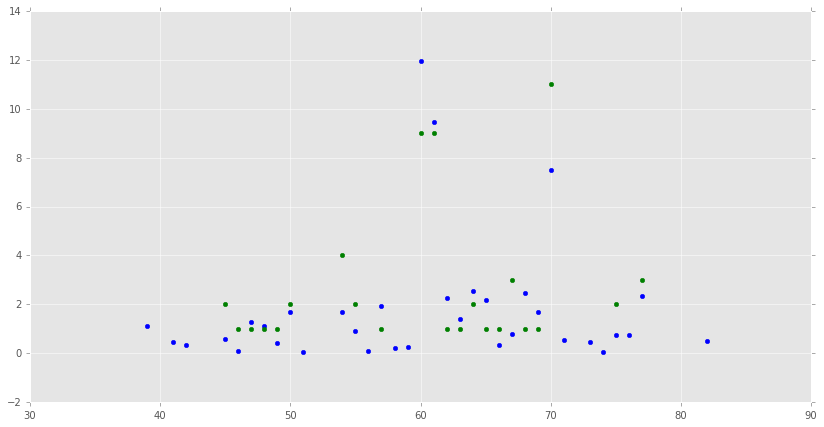

In [266]:
plt.scatter(binned_data.index, binned_data, color = 'blue')
plt.scatter(may_2_stations.index, may_2_stations, color = 'green')

plt.show()

All stations where bikes arrived were predicted for this station by the historical weekday data. However, we also predicted stations that didn't show up (although these were all low probabilities and could be filtered out). 

In [263]:
# Define a function that creates a matrix of probabilities of destination stations for this given hour for each starting station. 


# i.e. if Station 1 sends 1 bike to Station 2, and no other bikes to any othe station
# we estimate that if a bike leaves Station 1 it is bound for Station 2 100% of the time (p = 1.0)
# If Station 1 sends 2 bikes to Station 2, 1 bike to Station 3, and 1 bike to Station 4
# then the probabilities would be 0.50 (Station 2), 0.25 (Station 3), and 0.25 (Station 4)

In [92]:
# If a bike leaves a given station, return the probabilities of the destination stations to each station's bin

In [93]:
# Compare the binned probabilities with the actual bike destinations. Do they correlate? Should probs be rounded up?